### Считывание кластеризованных данных

In [1]:
import os
import pandas as pd

os.chdir('../../../')

In [14]:
df = pd.read_csv('data/lmsys-chat-1m/processed/kmeans_clusters.csv')
df.head()

,user_id,neutral_count,positive_count,negative_count,total_reformulations,total_words,total_spelling_errors,total_questions,cluster
0,0,0.000000,1.0,0.000000,0.0,11.0,0.0,0.000000,1
1,1,0.333333,0.5,0.166667,0.5,25.0,0.5,0.666667,1
2,2,0.000000,1.0,0.000000,0.0,66.0,0.0,0.000000,1
3,3,0.500000,0.5,0.000000,0.0,14.5,0.0,0.000000,0
4,4,1.000000,0.0,0.000000,0.0,18.0,3.0,0.000000,0


### Обучение классификатора

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from scipy.stats import loguniform
import time

X = df.drop(['user_id', 'cluster'], axis=1)
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_dist_lr = {
    'penalty': ['l2', None],
    'C': loguniform(1e-3, 10),  # регуляризация
    'solver': ['lbfgs', 'saga'],  # saga поддерживает большие и разреженные данные
    'max_iter': [500, 1000]
}

model_lr = LogisticRegression(random_state=42, multi_class='multinomial')

search_lr = RandomizedSearchCV(
    model_lr,
    param_distributions=param_dist_lr,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start = time.time()
search_lr.fit(X_train, y_train)
end = time.time()

print(f"Logistic Regression — лучшая модель: {search_lr.best_params_}")
print(f"Время подбора: {round(end - start, 2)} сек")

best_model = search_lr.best_estimator_
y_pred_lr = best_model.predict(X_test)

print("Качество (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression — лучшая модель: {'C': np.float64(0.02161894240657444), 'max_iter': 1000, 'penalty': None, 'solver': 'lbfgs'}
Время подбора: 247.67 сек
Качество (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11437
           1       1.00      0.99      0.99      8523
           2       0.97      0.97      0.97       324
           3       0.98      0.99      0.98      2065
           4       0.99      0.99      0.99      3351
           5       0.94      0.93      0.94       233

    accuracy                           0.99     25933
   macro avg       0.98      0.98      0.98     25933
weighted avg       0.99      0.99      0.99     25933



C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Проверка на переобучение

In [16]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

Train accuracy: 0.9932
Test accuracy:  0.9932


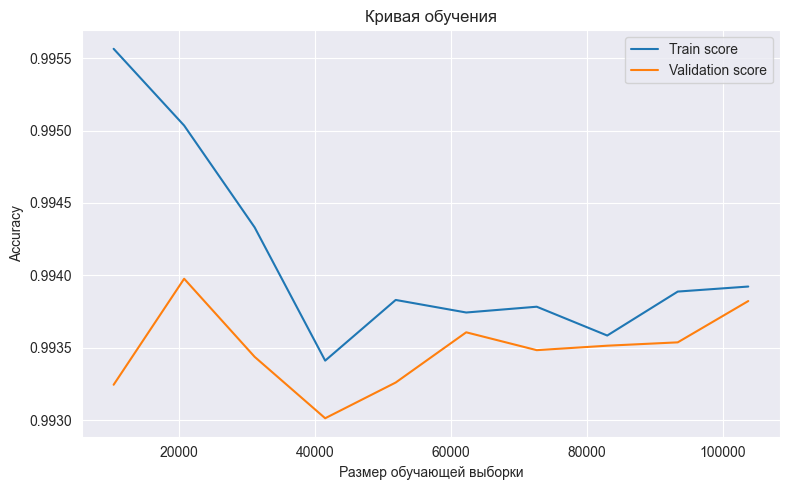

In [17]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривая обучения")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Сохраняем модель

In [18]:
import joblib

joblib.dump(best_model, 'models/logistic_regression/model.pkl')

['models/logistic_regression/model.pkl']

### Проверка без дубликатов

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from scipy.stats import loguniform
import time

X = df.drop(['user_id', 'cluster'], axis=1)
y = df['cluster']
X = X.drop_duplicates()
y = y.loc[X.index]  # пересинхронизация y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_dist_lr = {
    'penalty': ['l2', None],
    'C': loguniform(1e-3, 10),  # регуляризация
    'solver': ['lbfgs', 'saga'],  # saga поддерживает большие и разреженные данные
    'max_iter': [500, 1000]
}

model_lr = LogisticRegression(random_state=42, multi_class='multinomial')

search_lr = RandomizedSearchCV(
    model_lr,
    param_distributions=param_dist_lr,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

start = time.time()
search_lr.fit(X_train, y_train)
end = time.time()

print(f"Logistic Regression — лучшая модель: {search_lr.best_params_}")
print(f"Время подбора: {round(end - start, 2)} сек")

best_model = search_lr.best_estimator_
y_pred_lr = best_model.predict(X_test)

print("Качество (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression — лучшая модель: {'C': np.float64(0.02161894240657444), 'max_iter': 1000, 'penalty': None, 'solver': 'lbfgs'}
Время подбора: 58.84 сек
Качество (Logistic Regression):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3096
           1       0.99      0.98      0.98      1936
           2       0.98      0.98      0.98       252
           3       0.97      0.97      0.97      1211
           4       0.98      0.98      0.98      1195
           5       0.93      0.99      0.96       208

    accuracy                           0.98      7898
   macro avg       0.97      0.98      0.98      7898
weighted avg       0.98      0.98      0.98      7898



C:\Users\hqdem\PythonProjects\user-pattern-analysis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Проверка на переобучение

In [20]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

Train accuracy: 0.9840
Test accuracy:  0.9846


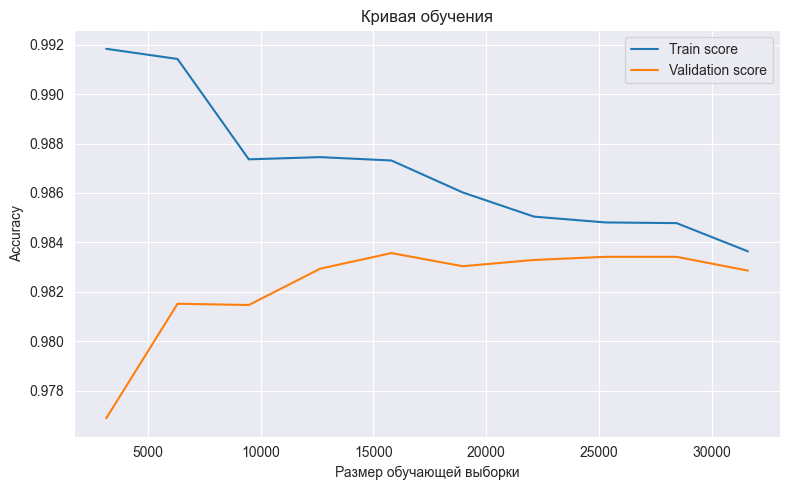

In [22]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, test_mean, label='Validation score')
plt.xlabel("Размер обучающей выборки")
plt.ylabel("Accuracy")
plt.title("Кривая обучения")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Сохраняем модель

In [23]:
import joblib

joblib.dump(best_model, 'models/logistic_regression/model_wo_duplicates.pkl')

['models/logistic_regression/model_wo_duplicates.pkl']